In [103]:
#copy this into the Continuous AP folder after cluster cutting
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sampRate=30000 #figure out how to get around hard coding this
spike_times=np.load('spike_times.npy')
st=spike_times/sampRate
spike_templates=np.load('spike_templates.npy')
spike_clusters=np.load('spike_clusters.npy')
cids=pd.read_table('cluster_info.tsv')
cids.head()

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,0,301.0,101.9,mua,19.176311,1,20.0,10.543538,noise,35886,0
1,1,190.6,106.5,mua,14.127209,15,160.0,6.923255,noise,23564,0
2,2,227.2,99.7,mua,15.683676,15,160.0,9.271944,noise,31558,0
3,3,318.3,inf,mua,14.507984,15,160.0,0.012634,mua,43,0
4,4,170.4,87.9,mua,12.783755,35,360.0,9.511396,noise,32373,0


In [3]:
cids_good=cids.query("group=='good'")
cids_good=cids_good.reset_index(drop=True)
np.shape(cids_good)
good_units=np.array(cids_good['id'])
cids_good.head()

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,13,351.9,0.9,good,21.665257,95,960.0,8.381417,good,28527,0
1,18,252.8,9.3,good,18.677330,123,1240.0,34.779339,good,118375,0
2,20,348.9,8.9,good,26.365196,133,1340.0,10.151307,good,34551,0
3,21,255.6,12.2,mua,19.073395,133,1340.0,18.215119,good,61997,0
4,25,208.7,152.3,mua,12.679985,156,1580.0,1.620930,good,5517,0


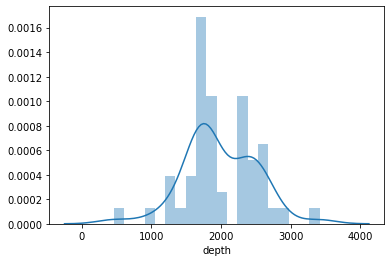

In [4]:
#number of cells along the length of the probe
ax=sns.distplot(cids_good['depth'], bins=20)
plt.savefig('numcells_alongprobe.svg')

In [104]:
histology=pd.read_csv('NP1_electrode_locations.csv')
histology.head()

,upperBorder,lowerBorder,acronym,name,avIndex
0,0,210,VISal2/3,Anterolateral visual area layer 2/3,167
1,210,350,AUDpo2/3,Posterior auditory area layer 2/3,146
2,350,440,AUDpo4,Posterior auditory area layer 4,147
3,440,790,AUDpo5,Posterior auditory area layer 5,148
4,790,980,AUDpo6a,Posterior auditory area layer 6a,149


In [96]:
import warnings
warnings.filterwarnings("ignore")        

s=pd.Series(cids_good['depth'])
top=np.array(histology['upperBorder'])
bottom=np.array(histology['lowerBorder'])
name=histology['acronym']

brain_area=[None]*len(s)
for i in range(len(top)-1):
    isbetween=s.between(top[i],bottom[i], inclusive=True)
    this_ind=s[isbetween].index.values
    
    if len(this_ind)>1:
        for j in range(len(this_ind)-1):
            brain_area[this_ind[j]]=name[i]
    elif len(this_ind)==0:
        this_ind=this_ind
    else:
        this_ind=np.asscalar(this_ind)
        brain_area[this_ind]=name[i]

cids_good.insert(0,'BrainArea', brain_area)
cids_good.head()

,BrainArea,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh
0,AUDpo6a,13,351.9,0.9,good,21.665257,95,960.0,8.381417,good,28527,0
1,alv,18,252.8,9.3,good,18.677330,123,1240.0,34.779339,good,118375,0
2,CA1,20,348.9,8.9,good,26.365196,133,1340.0,10.151307,good,34551,0
3,CA1,21,255.6,12.2,mua,19.073395,133,1340.0,18.215119,good,61997,0
4,CA1,25,208.7,152.3,mua,12.679985,156,1580.0,1.620930,good,5517,0


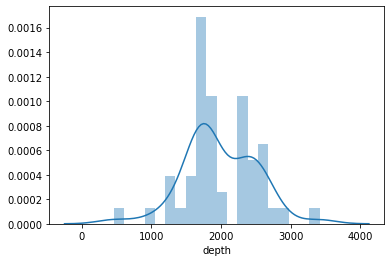

In [108]:
ax=sns.distplot(cids_good['depth'],bins=20)
plt.savefig('numcells_alongprobe.svg')

In [109]:
#load in events
cwd=os.getcwd()
from os.path import dirname as up

abs_path = up(up(up(cwd)))
print(abs_path)

Y:\froemkelabspace\Macayla\Data\NP_Recordings\2020-08-28_12-15-37_WT


In [110]:
events=np.load((os.path.join(abs_path,r'events\Neuropix-PXI-slot2-probe1\TTL_1\event_timestamps.npy')))
events=events/(sampRate/100)
print(events[-1])

281116.4266666667


In [111]:
#make a dataframe out of spiketimes and cluster ids?
st = np.array(st).flatten()
spikes=pd.DataFrame()
spikes['Spike Times']=st.tolist()
spikes['Cluster ID']=spike_clusters.tolist()

In [112]:
good_spikes=spikes.loc[spikes['Cluster ID'].isin(good_units)]
good_spikes=good_spikes.sort_values(by=['Cluster ID'])
good_spikes.head()

,Spike Times,Cluster ID
582652,619.597167,13
1190831,1408.743667,13
480210,499.524100,13
1377917,1697.611933,13
1566803,2016.441067,13


In [113]:
max(good_spikes['Spike Times'])

3403.5957333333336

In [114]:
import elephant.conversion as conv
import neo as n
import quantities as pq
    
num_cells=np.unique(good_spikes['Cluster ID'])
spike_matrix=[]

import warnings
warnings.filterwarnings("ignore")

for i in range(len(num_cells)):
    this_cell_ind=good_spikes['Cluster ID']==num_cells[i]
    this_cell=good_spikes[this_cell_ind]
    this_cell=this_cell.sort_values('Spike Times')
    spike_times=this_cell['Spike Times']
    a = n.SpikeTrain([spike_times] * pq.s,
                 t_stop=round(max(good_spikes['Spike Times'])) * pq.s)
    x = conv.BinnedSpikeTrain(a, n_bins=round(max(good_spikes['Spike Times']))*100, bin_size=.01 * pq.s,
                          t_start=0 * pq.s)
    x=(x.to_array())
    x=x.flatten()
    spike_matrix.append(x)

spike_matrix=np.array(spike_matrix)
#print(spike_matrix[-5:-1,0:99])

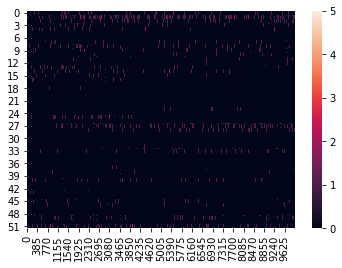

In [117]:
#heatmap of all spikes from all neurons
ax=sns.heatmap(spike_matrix[:,1:10000])

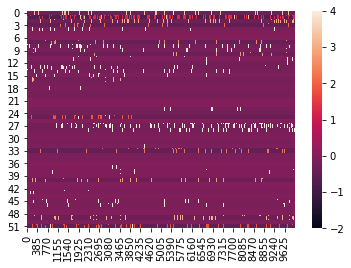

In [118]:
#normalized heatmap, all time bins
from scipy import stats

spike_matrix_norm=stats.zscore(spike_matrix,axis=1)
#print(spike_matrix_norm[-5:-1,0:99])
ax2=sns.heatmap(spike_matrix_norm[:,1:10000], vmin=-2, vmax=4)

In [119]:
#baseline is 0 through events[0]
#switches between stim are ~120 seconds apart, pure tones 
delt_events=np.round(np.diff(events),2)

#print(event_ts[0:50])
np.shape(delt_events)

(1009,)

In [120]:
stim_break=delt_events>2000
break_inds=np.where(stim_break)[0] #in my case there should be 3 unless the notes specify otherwise
print(break_inds)

[279 519 799]


In [121]:
#pure tones- 1st and 3rd- this might not be the best way to show this? look more at micheles paper
pt1=events[0:break_inds[0]-1];pt1_start=np.round(pt1[::2]); pt1_start=pt1_start.astype(int)
pt1_end=np.round(pt1[1::2]); pt1_end=pt1_end.astype(int)
pt2=events[break_inds[1]-1:break_inds[2]-1]; pt2_start=np.round(pt2[::2]); pt2_start=pt2_start.astype(int)
pt2_end=np.round(pt2[1::2]);pt2_end=pt2_end.astype(int)

#pt_start=np.append(pt1_start,pt2_start)
#pt_end=np.append(pt1_end,pt2_end)

pt_start=pt1_start
pt_end=pt1_end

#need to look at tucker davis to see which tones were on when
pt_spikes_in=[]
pt_spikes_out_mean=[]

for i in range(len(pt_start)-1):
    these_spikes_in=spike_matrix_norm[:,pt_start[i]:pt_end[i]]
    pt_spikes_in.append(these_spikes_in)
    these_spikes_out_mean=np.mean(spike_matrix_norm[:,pt_end[i]:pt_start[i+1]],axis=1) #this doesn't work because of the long gap in the middle
    pt_spikes_out_mean.append(these_spikes_out_mean)

In [ ]:
pt_spikes_in_mean=np.mean(pt_spikes_in,axis=2)

np.shape(pt_spikes_out_mean)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for a in [pt_spikes_in_mean, pt_spikes_out_mean]:
    sns.distplot(a)
ax.legend(labels=['on','off'])


In [ ]:
ax=sns.boxplot([pt_spikes_in_mean, pt_spikes_out_mean])

TypeError: 'Series' object is not callable

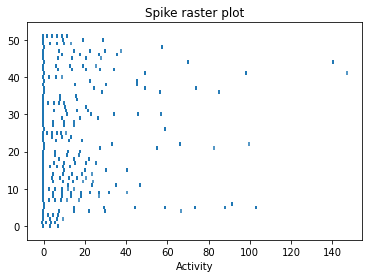

In [122]:
import matplotlib.pyplot as plot

plot.eventplot(spike_matrix_norm)     
plot.title('Spike raster plot')
plot.xlabel('Activity')
plot.ylabel('Neuron')
plot.show()